In [1]:
import numpy as np
import json, random
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
except Exception:
    torch = None

## Data Inspection

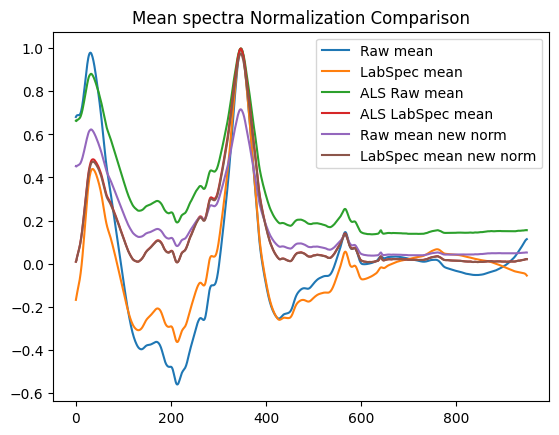

In [2]:
from pyspectral.dataset import SpectraPair
from pyspectral.features import PeakNormConfig, GlobalPeakNorm, ALS
from pyspectral.config import DATA_DIR

DATA = DATA_DIR
ANN  = DATA / "annotations_S80.csv"
peak_cfg = PeakNormConfig(mode=GlobalPeakNorm())

pairs_new_norm , arts_new_norm  = SpectraPair.from_annotations(ANN, DATA, peak_cfg=peak_cfg, baseline_method=None)
pairs_def, arts_def = SpectraPair.from_annotations(ANN, DATA, spike_k= 9, baseline_method = 6) 
pairs_als, arts_als = SpectraPair.from_annotations(ANN, DATA, spike_k= 9, baseline_method=ALS) 
X = pairs_def.X_raw.astype(np.float32)   # (N,C)
Y = pairs_def.Y_proc.astype(np.float32)  # (N,C)
X_new_norm = pairs_new_norm.X_raw.astype(np.float32)   # (N,C)
Y_new_norm  = pairs_new_norm.Y_proc.astype(np.float32)  # (N,C)
X_als = pairs_als.X_raw.astype(np.float32)   # (N,C)
Y_als  = pairs_als.Y_proc.astype(np.float32)  # (N,C)
N, C = X.shape

H, W = 8, 8
assert N == H*W, f"Expected {H}x{W} grid -> N={H*W}, got N={N}"

plt.plot(X.mean(0), label="Raw mean"); plt.plot(Y.mean(0), label="LabSpec mean");
plt.plot(X_als.mean(0), label="ALS Raw mean"); plt.plot(Y_als.mean(0), label="ALS LabSpec mean");
plt.plot(X_new_norm.mean(0), label="Raw mean new norm"); plt.plot(Y_new_norm.mean(0), label="LabSpec mean new norm");
plt.legend(); plt.title("Mean spectra Normalization Comparison"); plt.show()

## Baselines

### Classical Baseline

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error as RMSE

cv = KFold(n_splits=4, shuffle=True, random_state=42)

def classic(pairs, lbl):
    yhat_diag  = pairs.diagonal_affine_predict(cv)                   
    yhat_pcr   = pairs.pcr_predict(cv)
    yhat_enet  = pairs.multitask_elasticnet_predict(cv)
    print(f"{lbl} Diagonal affine (OOF) RMSE: {RMSE(Y, yhat_diag):.4f}")
    print(f"{lbl} PCR (OOF) RMSE:             {RMSE(Y, yhat_pcr):.4f}")
    print(f"{lbl} ElasticNet (OOF) RMSE:      {RMSE(Y, yhat_enet):.4f}")
    print("-"*12)
    return yhat_diag, yhat_pcr, yhat_enet

yhat_d_def, yhat_p_def, yhat_e_def = classic(pairs_def, "default")
yhat_d_n, yhat_p_n, yhat_e_n = classic(pairs_new_norm, "new norm")
yhat_d_a, yhat_p_a, yhat_e_a = classic(pairs_als, "ALS")



100%|██████████| 4/4 [00:34<00:00,  8.74s/it]


default Diagonal affine (OOF) RMSE: 0.7470
default PCR (OOF) RMSE:             0.7852
default ElasticNet (OOF) RMSE:      0.0067
------------


100%|██████████| 4/4 [01:12<00:00, 18.04s/it]


new norm Diagonal affine (OOF) RMSE: 0.4820
new norm PCR (OOF) RMSE:             0.6872
new norm ElasticNet (OOF) RMSE:      0.1430
------------


100%|██████████| 4/4 [00:27<00:00,  6.81s/it]

ALS Diagonal affine (OOF) RMSE: 0.5291
ALS PCR (OOF) RMSE:             0.6538
ALS ElasticNet (OOF) RMSE:      0.1453
------------


### Train a low-rank linear neural network mapper & cache OOF preds

In [10]:
from pyspectral.modeling.train import cv_train_model
from pyspectral.config import ModelType
rank = 12

oof_stats_def = cv_train_model(
    spectral_pairs=pairs_def,
    arts=arts_def,
    n_splits=4,
    epochs=10, # tested 10-20 is around where improvement stops
    lr=2e-4,
    model_type=ModelType.LRSM,  # or ModelType.LRSM
    rank=rank,
    verbose=True,
)
oof_stats_nnorm = cv_train_model(
    spectral_pairs=pairs_new_norm,
    arts=arts_def,
    n_splits=4,
    epochs=10, # tested 10-20 is around where improvement stops
    lr=2e-4,
    model_type=ModelType.LRSM,  # or ModelType.LRSM
    rank=rank,
    verbose=True,
)
oof_stats_als = cv_train_model(
    spectral_pairs=pairs_als,
    arts=arts_als,
    n_splits=4,
    epochs=10, # tested 10-20 is around where improvement stops
    lr=2e-4,
    model_type=ModelType.LRSM,  # or ModelType.LRSM
    rank=rank,
    verbose=True,
)

print(f"{oof_stats_def=}") 
print(f"{oof_stats_nnorm=}") 
print(f"{oof_stats_als=}") 
LR_pred_def = oof_stats_def.pred_orig  # (N,C) in original units
LR_pred_nnorm = oof_stats_nnorm.pred_orig  
LR_pred_als = oof_stats_als.pred_orig  


 25%|██▌       | 1/4 [02:13<06:39, 133.19s/it]

Fold 1/4 | train loss=0.247 | test MSE=0.389 | best test RMSE=0.559 | frac improved vs identity=0.812


 50%|█████     | 2/4 [04:26<04:26, 133.21s/it]

Fold 2/4 | train loss=0.267 | test MSE=0.448 | best test RMSE=0.588 | frac improved vs identity=1.000


 75%|███████▌  | 3/4 [06:39<02:13, 133.34s/it]

Fold 3/4 | train loss=0.247 | test MSE=0.295 | best test RMSE=0.451 | frac improved vs identity=0.688


100%|██████████| 4/4 [08:52<00:00, 133.13s/it]


Fold 4/4 | train loss=0.266 | test MSE=0.352 | best test RMSE=0.509 | frac improved vs identity=0.875


 25%|██▌       | 1/4 [02:11<06:35, 131.82s/it]

Fold 1/4 | train loss=0.61 | test MSE=0.731 | best test RMSE=0.827 | frac improved vs identity=1.000


 50%|█████     | 2/4 [04:21<04:21, 130.73s/it]

Fold 2/4 | train loss=0.661 | test MSE=0.965 | best test RMSE=0.97 | frac improved vs identity=1.000


 75%|███████▌  | 3/4 [06:35<02:12, 132.26s/it]

Fold 3/4 | train loss=0.706 | test MSE=0.569 | best test RMSE=0.714 | frac improved vs identity=0.875


100%|██████████| 4/4 [08:45<00:00, 131.40s/it]


Fold 4/4 | train loss=0.559 | test MSE=0.966 | best test RMSE=0.928 | frac improved vs identity=0.938


 25%|██▌       | 1/4 [02:10<06:31, 130.50s/it]

Fold 1/4 | train loss=0.48 | test MSE=0.638 | best test RMSE=0.768 | frac improved vs identity=1.000


 50%|█████     | 2/4 [04:23<04:24, 132.21s/it]

Fold 2/4 | train loss=0.532 | test MSE=0.648 | best test RMSE=0.794 | frac improved vs identity=1.000


 75%|███████▌  | 3/4 [06:35<02:11, 131.82s/it]

Fold 3/4 | train loss=0.488 | test MSE=0.437 | best test RMSE=0.615 | frac improved vs identity=0.938


100%|██████████| 4/4 [08:48<00:00, 132.03s/it]

Fold 4/4 | train loss=0.479 | test MSE=0.883 | best test RMSE=0.881 | frac improved vs identity=0.938
oof_stats_def=OOF RMSE (standardized space): 0.582800
Diagonal affine OOF RMSE (std):  0.759512
Diagonal affine OOF RMSE (orig): 0.007902
OOF RMSE (original units):    0.006617
oof_stats_nnorm=OOF RMSE (standardized space): 0.898645
Diagonal affine OOF RMSE (std):  1.021143
Diagonal affine OOF RMSE (orig): 0.012424
OOF RMSE (original units):    0.009082
oof_stats_als=OOF RMSE (standardized space): 0.806726
Diagonal affine OOF RMSE (std):  0.970796
Diagonal affine OOF RMSE (orig): 0.011117
OOF RMSE (original units):    0.008026


## Summarize models

In [13]:
import polars as pl
df = pl.DataFrame(
    {
        "model": ["def diag_affine", "def PCR", "def ElasticNet", f"def LowRank_r{rank}", 
        "nnorm diag_affine", "nnorm PCR", "nnorm ElasticNet", f"nnorm LowRank_r{rank}",
        "ALS diag_affine", "ALS PCR", "ALS ElasticNet", f"ALS LowRank_r{rank}"
        ],
        "oof_rmse": [
            RMSE(Y, yhat_d_def), RMSE(Y, yhat_p_def), RMSE(Y, yhat_e_def), RMSE(Y, LR_pred_def),
            RMSE(Y, yhat_d_n), RMSE(Y, yhat_p_n), RMSE(Y, yhat_e_n), RMSE(Y, LR_pred_nnorm),
            RMSE(Y, yhat_d_a), RMSE(Y, yhat_p_a), RMSE(Y, yhat_e_a), RMSE(Y, LR_pred_als)
            ]
    }
).sort("oof_rmse") # sort table in terms of rmse
df

model,oof_rmse
str,f64
"""def LowRank_r12""",0.005526
"""def ElasticNet""",0.006708
"""nnorm LowRank_r12""",0.143018
"""nnorm ElasticNet""",0.143045
"""ALS LowRank_r12""",0.145142
…,…
"""ALS diag_affine""",0.529121
"""ALS PCR""",0.653813
"""nnorm PCR""",0.687173


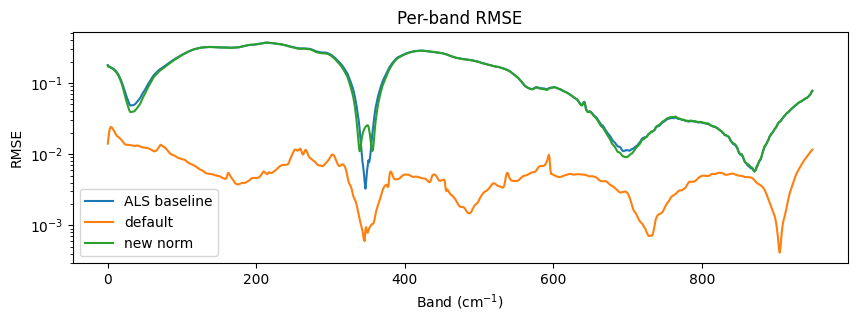

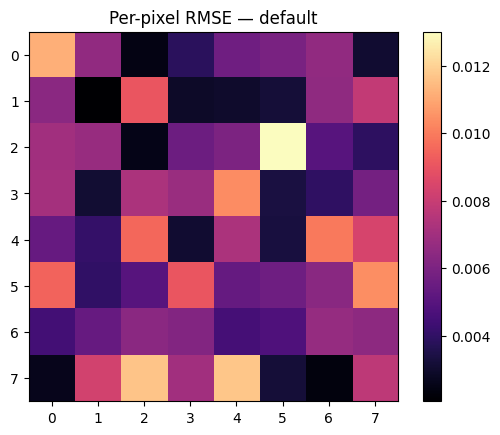

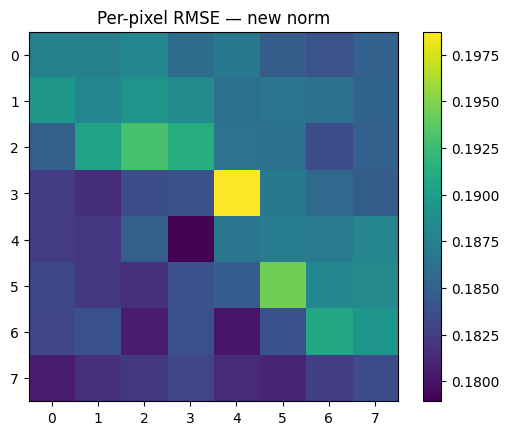

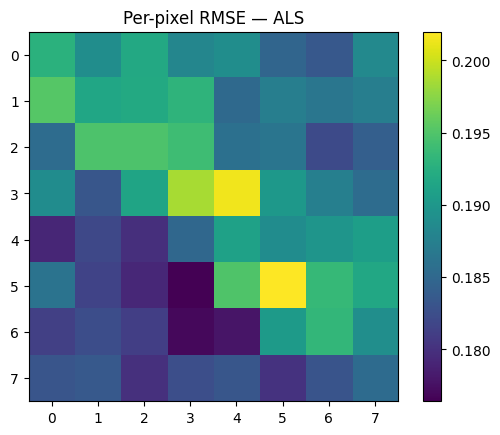

In [16]:
from pyspectral.plots import rmse_per_pixel
x_label = r"Band ($\text{cm}^{-1}$)"
per_band_rmse_def = np.sqrt(((Y - LR_pred_def)**2).mean(axis=0))
per_band_rmse_nnorm = np.sqrt(((Y - LR_pred_nnorm)**2).mean(axis=0))
per_band_rmse_als = np.sqrt(((Y - LR_pred_als)**2).mean(axis=0))
plt.figure(figsize=(10,3));plt.plot(per_band_rmse_als, label="ALS baseline"); plt.plot(per_band_rmse_def , label="default"); plt.plot(per_band_rmse_nnorm, label="new norm")
plt.title("Per-band RMSE"); plt.xlabel(x_label); plt.ylabel("RMSE"); plt.yscale("log"); plt.legend(); plt.show()

rmse_px_def = rmse_per_pixel(Y, LR_pred_def).reshape(H,W)
rmse_px_nnorm = rmse_per_pixel(Y, LR_pred_nnorm).reshape(H,W)
rmse_px_als = rmse_per_pixel(Y, LR_pred_als).reshape(H,W)
plt.imshow(rmse_px_def, cmap="magma"); plt.colorbar(); plt.title("Per-pixel RMSE — default"); plt.show()
plt.imshow(rmse_px_nnorm); plt.colorbar(); plt.title("Per-pixel RMSE — new norm"); plt.show()
plt.imshow(rmse_px_als); plt.colorbar(); plt.title("Per-pixel RMSE — ALS"); plt.show()

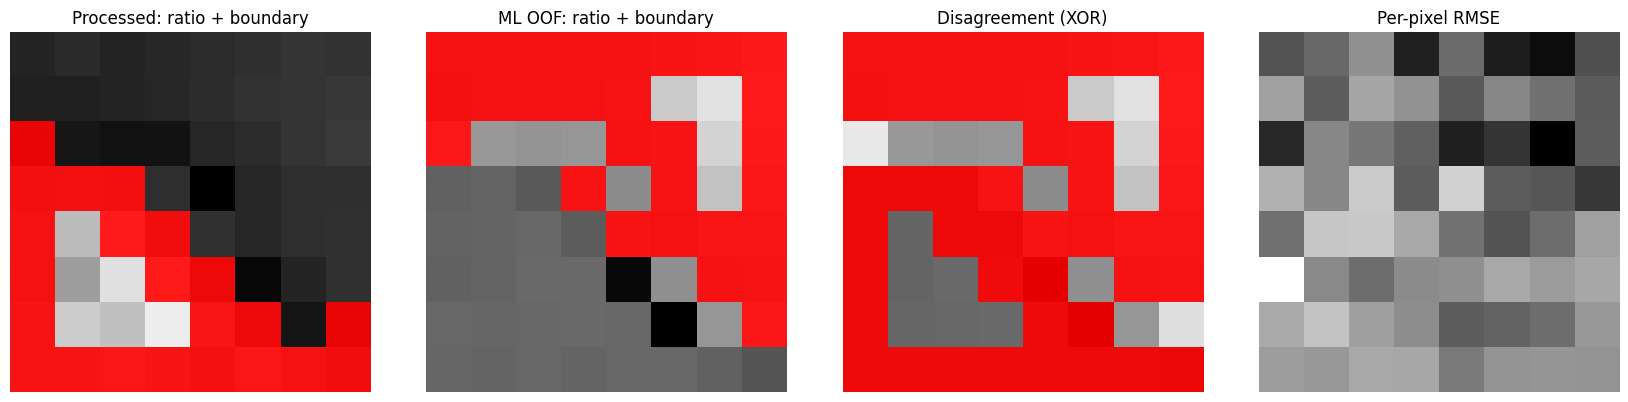

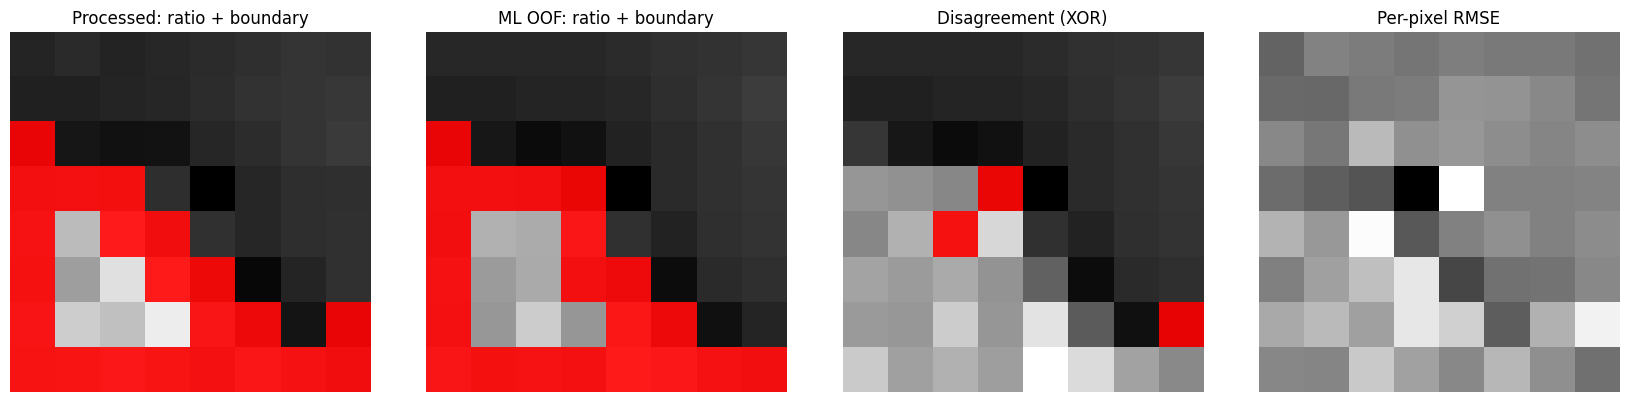

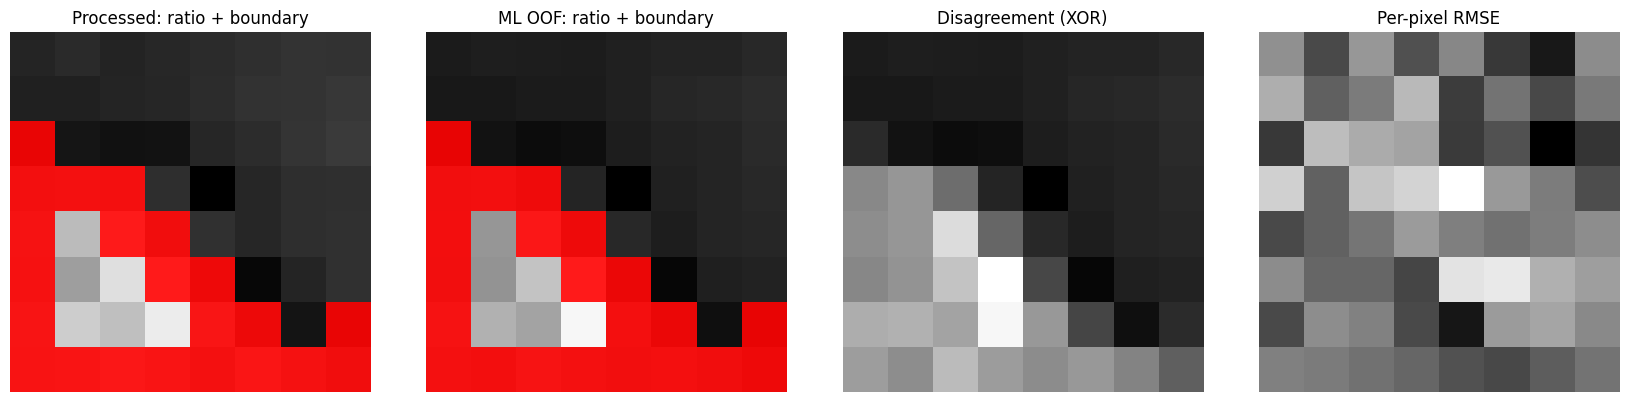

In [18]:
import pyspectral.modeling.predict as predict
import pyspectral.plots as plot
import importlib
importlib.reload(predict); importlib.reload(plot);
scene_idx = 0  # pick a scene 
pdata_def = predict.predict_cube(scene_idx, oof_stats_def, base_dir=DATA, csv_path=ANN)
metrics_def = plot.compare_boundaries(pdata_def, vid_labels=None)

pdata_nnorm = predict.predict_cube(scene_idx, oof_stats_nnorm, base_dir=DATA, csv_path=ANN)
metrics_nnorm = plot.compare_boundaries(pdata_nnorm, vid_labels=None)

pdata_als = predict.predict_cube(scene_idx, oof_stats_als, base_dir=DATA, csv_path=ANN)
metrics_als = plot.compare_boundaries(pdata_als, vid_labels=None)

